In [18]:
import os

from PIL import Image
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models


In [2]:
data_dir = '/content/drive/MyDrive/Apple Dataset'

class_folders = os.listdir(data_dir)
image_paths = []
labels = []

for class_folder in class_folders:
    class_path = os.path.join(data_dir, class_folder)
    image_files = os.listdir(class_path)
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        image_paths.append(image_path)
        labels.append(class_folder)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})

In [3]:
df.head()

,image_path,label
0,/content/drive/MyDrive/Apple Dataset/_00/01efa...,_00
1,/content/drive/MyDrive/Apple Dataset/_00/01b32...,_00
2,/content/drive/MyDrive/Apple Dataset/_00/02cd3...,_00
3,/content/drive/MyDrive/Apple Dataset/_00/02fe2...,_00
4,/content/drive/MyDrive/Apple Dataset/_00/02a0f...,_00


In [4]:
print("The classes:\n", np.unique(df['label']))

The classes:
 ['_00' '_01']


In [5]:
class_counts = df['label'].value_counts()
print(class_counts)

label
_00    200
_01    200
Name: count, dtype: int64


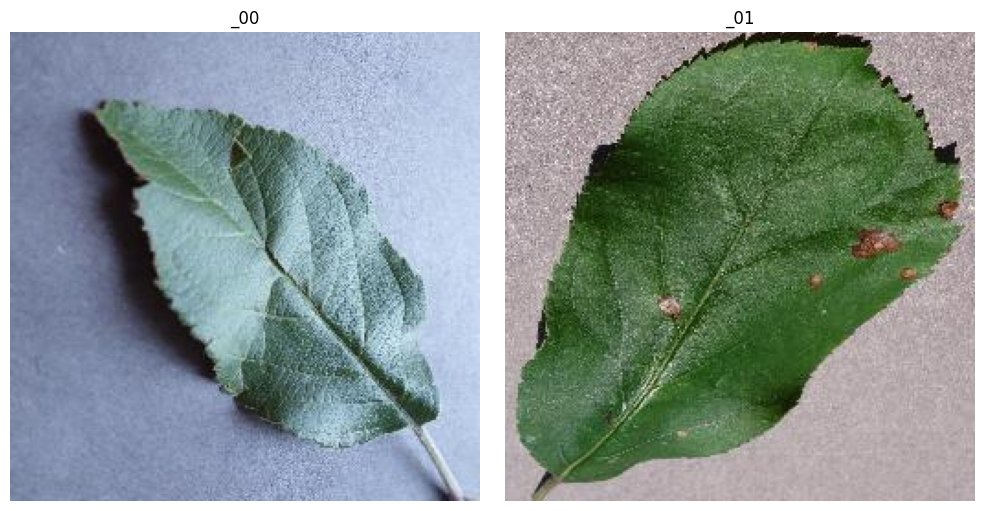

In [8]:
# Display sample images from each class
num_classes = len(df['label'].unique())
num_images_per_row = 3
num_rows = (num_classes + num_images_per_row - 1) // num_images_per_row

plt.figure(figsize=(15, 5 * num_rows))  # Adjust figure size based on the number of rows

for i, plant_class in enumerate(df['label'].unique()):
    plt.subplot(num_rows, num_images_per_row, i + 1)

    # Inside the loop for displaying sample images
    image_path = os.path.join(data_dir, df[df['label'] == plant_class]['image_path'].iloc[0])

    # Check if the image exists and can be loaded
    if os.path.exists(image_path):
        sample_image = cv2.imread(image_path)
        if sample_image is not None:
            plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
            plt.title(plant_class)
            plt.axis('off')
        else:
            print(f"Error: Unable to load image from path: {image_path}")
    else:
        print(f"Error: Image path does not exist: {image_path}")

plt.tight_layout()
plt.show()

(256, 256, 3)


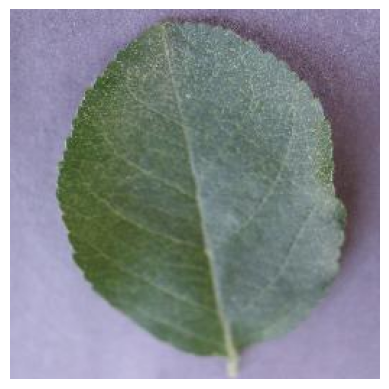

In [10]:
image_path = '/content/drive/MyDrive/Apple Dataset/_00/00a6039c-e425-4f7d-81b1-d6b0e668517e___RS_HL 7669.JPG'

img = mpimg.imread(image_path)
print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()

In [11]:
image_path = '/content/drive/MyDrive/Apple Dataset/_00/00a6039c-e425-4f7d-81b1-d6b0e668517e___RS_HL 7669.JPG'

img = mpimg.imread(image_path)
print(img)

[[[143 136 169]
  [148 141 174]
  [149 142 175]
  ...
  [154 144 178]
  [150 140 174]
  [140 130 164]]

 [[142 135 168]
  [145 138 171]
  [144 137 170]
  ...
  [151 141 175]
  [153 143 177]
  [151 141 175]]

 [[149 142 175]
  [148 141 174]
  [142 135 168]
  ...
  [146 136 170]
  [150 140 174]
  [155 145 179]]

 ...

 [[180 176 209]
  [180 176 209]
  [181 177 210]
  ...
  [160 153 186]
  [160 153 186]
  [160 153 186]]

 [[180 176 209]
  [180 176 209]
  [181 177 210]
  ...
  [161 154 187]
  [161 154 187]
  [162 155 188]]

 [[180 176 209]
  [180 176 209]
  [181 177 210]
  ...
  [162 155 188]
  [162 155 188]
  [163 156 189]]]


In [12]:
img_size = 224
batch_size = 32

In [13]:
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of data for validation
)

In [15]:
train_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

Found 320 images belonging to 2 classes.


In [16]:
validation_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

Found 80 images belonging to 2 classes.


In [19]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (img_size,img_size,3)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation = 'relu'))
model.add(layers.Dense(train_generator.num_classes, activation = 'softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 256)               4

In [21]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [22]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    epochs = 5,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size
)

Epoch 1/5
10/10 [==============================] - 43s 4s/step - loss: 6.8597 - accuracy: 0.4938 - val_loss: 0.5716 - val_accuracy: 0.5156
Epoch 2/5
10/10 [==============================] - 2s 206ms/step - loss: 0.4462 - accuracy: 0.8000 - val_loss: 0.2440 - val_accuracy: 0.9688
Epoch 3/5
10/10 [==============================] - 2s 174ms/step - loss: 0.2220 - accuracy: 0.9219 - val_loss: 0.2677 - val_accuracy: 0.8906
Epoch 4/5
10/10 [==============================] - 2s 210ms/step - loss: 0.0722 - accuracy: 0.9875 - val_loss: 0.1236 - val_accuracy: 0.9219
Epoch 5/5
10/10 [==============================] - 2s 177ms/step - loss: 0.0196 - accuracy: 1.0000 - val_loss: 0.0719 - val_accuracy: 0.9688


In [23]:
print("Evaluating model...")
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Evaluating model...
2/2 [==============================] - 1s 343ms/step - loss: 0.0617 - accuracy: 0.9688
Validation Accuracy: 96.88%


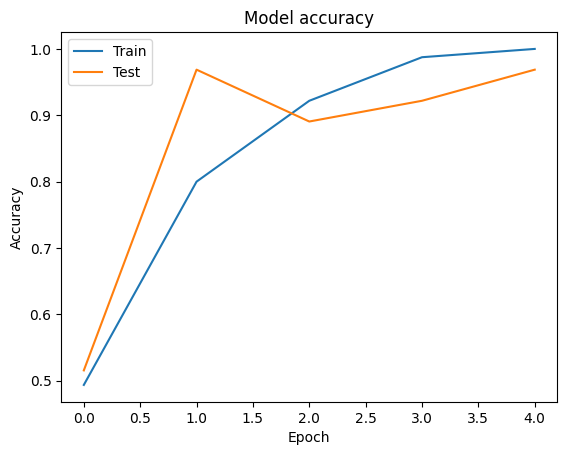

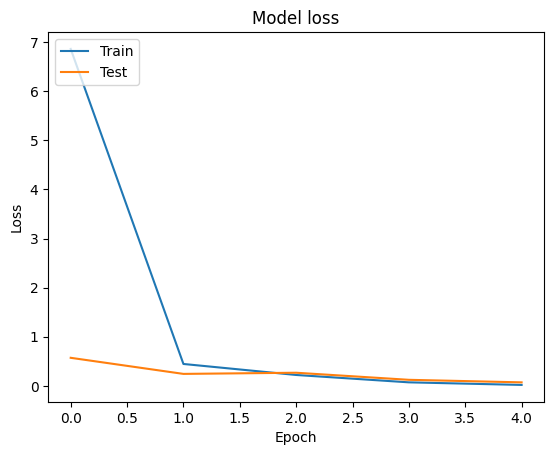

In [24]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [25]:
plt.savefig('Demo.png')

<Figure size 640x480 with 0 Axes>